In [ ]:
!pip install "tensorflow==2.12.0"
!pip install ampligraph

In [ ]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

In [1]:
df = pd.read_csv("characters.csv")

NameError: name 'pd' is not defined

In [ ]:
df.isna().sum()

,0
_id,0
name,0
gender,0
born,0
origin,0
death,0
status,0
culture,0
religion,0
titles/0,0


In [ ]:
df =df.fillna("unknown")

In [ ]:
df["train"] = df._id < 60

In [ ]:
df.describe()

,_id,seasons/0
count,76.000000,76.000000
mean,38.500000,2.289474
std,22.083176,1.655824
min,1.000000,1.000000
25%,19.750000,1.000000
50%,38.500000,1.500000
75%,57.250000,3.000000
max,76.000000,7.000000


In [ ]:
triples = []
for _, row in df[df["train"]].iterrows():

    # Match characteristics
    origin = (row["name"], "hasOrigin", row["origin"])
    religion = (row["name"], "hasReligion", row["religion"])
    house = (row["name"], "fromHouse", row["house"])
    father = (row["name"], "hasFather", row["father"])
    mother = (row["name"], "hasMother", row["mother"])
    culture = (row["name"], "hasCulture", row["culture"])

    triples.extend((origin, religion, house, father, mother, culture))

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Daenerys Targaryen")]

,subject,predicate,object
0,Daenerys Targaryen,hasOrigin,Dragonstone
1,Daenerys Targaryen,hasReligion,unknown
2,Daenerys Targaryen,fromHouse,Targaryen
3,Daenerys Targaryen,hasFather,Aerys II Targaryen
4,Daenerys Targaryen,hasMother,Rhaella Targaryen
5,Daenerys Targaryen,hasCulture,Valyrian


In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10)

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (344, 3)
Test set size:  (10, 3)


In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=10,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
import tensorflow as tf
model = ScoringBasedEmbeddingModel(k=7,
                                   eta=2,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [ ]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
59/59 [==============================] - 1s 24ms/step - loss: 6.5136
Epoch 2/300
59/59 [==============================] - 0s 2ms/step - loss: 6.5087
Epoch 3/300
59/59 [==============================] - 0s 2ms/step - loss: 6.5036
Epoch 4/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4945
Epoch 5/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4865
Epoch 6/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4781
Epoch 7/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4679
Epoch 8/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4575
Epoch 9/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4464
Epoch 10/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4309
Epoch 11/300
59/59 [==============================] - 0s 2ms/step - loss: 6.4134
Epoch 12/300
59/59 [==============================] - 0s 2ms/step - loss: 6.3931
Epoch 13/300
59/59 [================

In [ ]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

2/2 [==============================] - 1s 667ms/step


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.40
MR: 19.10
Hits@10: 0.65
Hits@3: 0.45
Hits@1: 0.25


In [ ]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

fatal: destination path 'incf.countryutils' already exists and is not an empty directory.
Processing /content/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21366 sha256=6c5faf7dff7911815e9471cb6985a08a16105f331752a0cec9966545bfa5697c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dz2kr234/wheels/c5/6d/14/97b9e81573cddb65059b909bb41583ef4b24011da29aac7d7e
Successfully built incf.countryutils
  Attempting uninstall: incf.countryutils
    Found existing installation: incf.countryutils 1.2
    Uninstalling incf.countryutils-1.2:
      Successfully uninstalled incf.countryutils-1.2


In [ ]:
!pip install adjustText

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [ ]:
cuisine = list(set([row['name'] for index, row in df[df["train"]].iterrows()]))
cuisine_embeddings = dict(zip(cuisine, model.get_embeddings(cuisine)))

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in cuisine_embeddings.values()]))

59 59 59


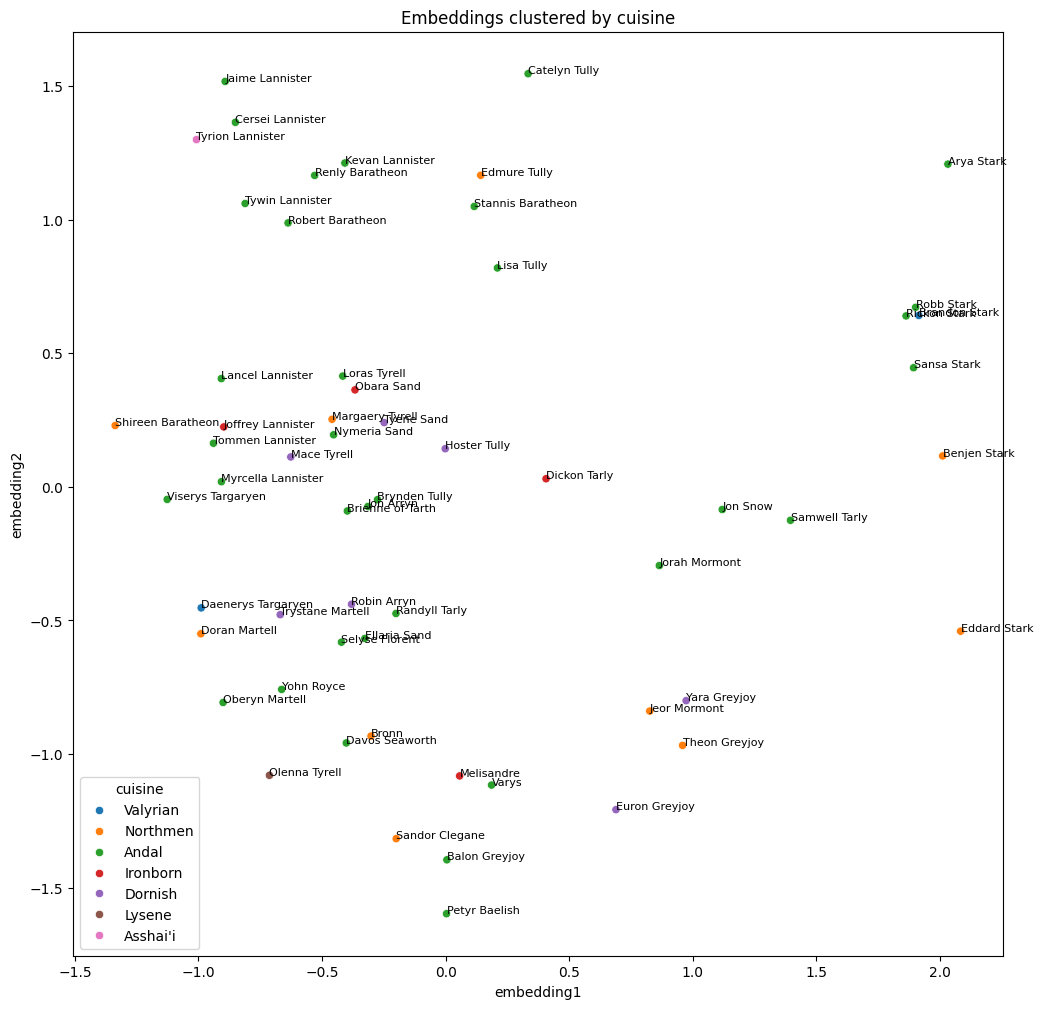

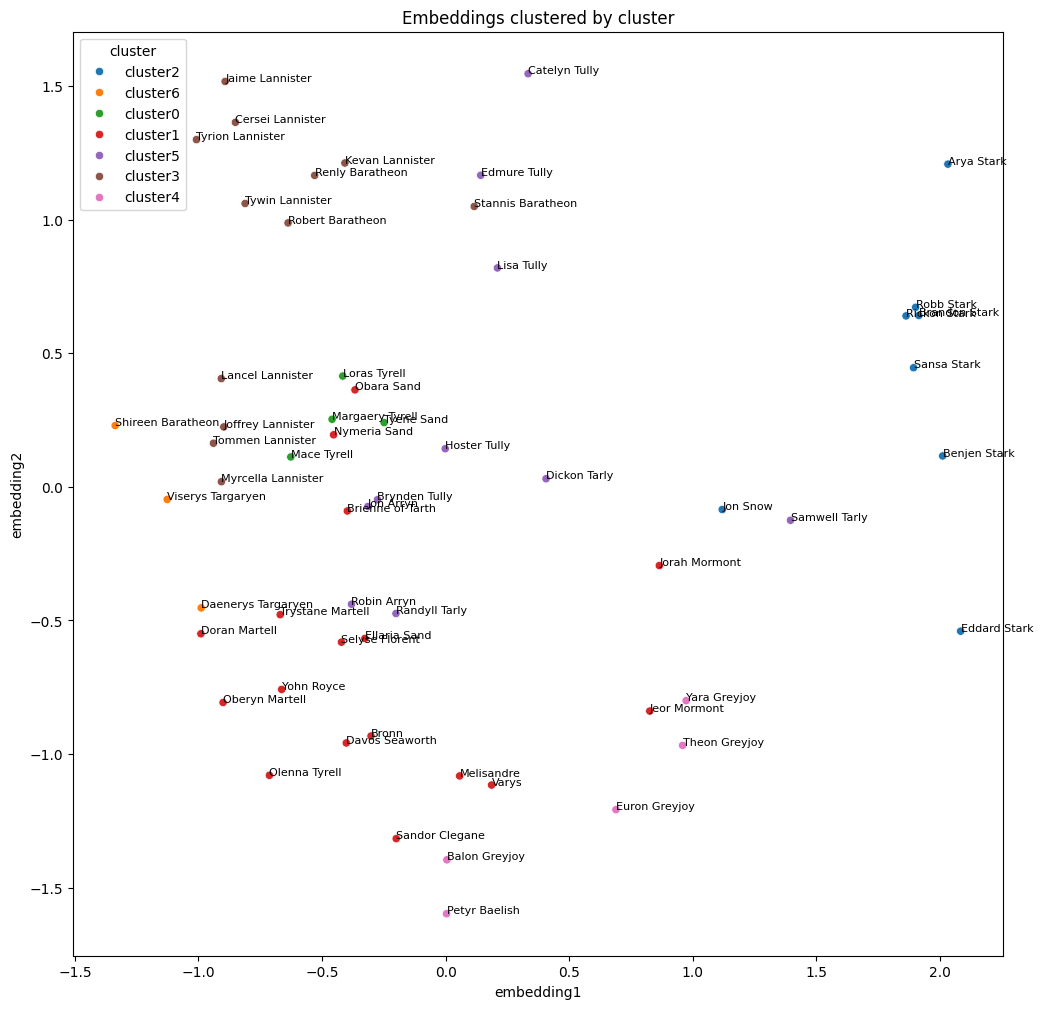

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ampligraph.discovery import find_clusters
import matplotlib.pyplot as plt
import seaborn as sns

embeddings_2d = PCA(n_components=2).fit_transform(np.array(list(cuisine_embeddings.values())))
cuisine_array = np.array(cuisine)


# Кластеризация
clustering_algorithm = KMeans(n_clusters=7, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(cuisine_array, model, clustering_algorithm, mode='e')
print( len(cuisine), embeddings_2d.shape[0],len(clusters))
# Создание DataFrame для визуализации
plot_df = pd.DataFrame({
    "agents": cuisine,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "cuisine": df[df["train"]]["culture"],
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})

# Визуализация кластеров
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title(f"Embeddings clustered by {hue}".capitalize())
    sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue, palette="tab10")
    for _, point in plot_df.iterrows():
        plt.text(point['embedding1'], point['embedding2'], point["agents"], fontsize=8)
    plt.show()

# Визуализация кластеров по кухням и результатам кластеризации
plot_clusters("cuisine")
plot_clusters("cluster")

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.cuisine, plot_df.cluster)

0.025517359442180185

## Classification

In [ ]:
# Получаем уникальные жанры из DataFrame и сохраняем их в список
culture = list(df.culture.unique())

# Создаем новый столбец 'results' в DataFrame
# Каждый жанр преобразуется в уникальный индекс
df["results"] = df.culture.apply(lambda g: culture.index(g)).astype(int)

In [ ]:
df.results.value_counts(normalize=True)

,proportion
results,
2,0.473684
1,0.171053
4,0.092105
3,0.052632
0,0.039474
9,0.039474
5,0.013158
6,0.013158
7,0.013158


### Original dataset

First install xgboost with `pip install xgboost`.

In [ ]:
!pip install xgboost

In [ ]:
new_df = df[["results", "train"]].copy()
new_df

,results,train
0,0,True
1,0,True
2,1,True
3,1,True
4,1,True
...,...,...
71,2,False
72,14,False
73,15,False
74,0,False


In [ ]:
new_df.neutral = new_df.neutral.astype(bool)

Split date:

In [ ]:
new_df["year"] = df["date"].apply(lambda x: int(x[:4]))
new_df["month"] = df["date"].apply(lambda x: int(x[5:7]))
new_df["day"] = df["date"].apply(lambda x: int(x[8:]))

Apply one hot encoding:

In [ ]:
encoded_cols = pd.get_dummies(df[["religion", "origin", "house", "father", "mother"]])
encoded_cols

,religion_Drowned God,religion_Great Stallion,religion_Many-Faced God,religion_Old Gods,religion_R'hllor,religion_The Sevens,religion_unknown,origin_Asshai,origin_Baelish Castle,origin_Bear Island,...,mother_Lyanna Stark,mother_Lyarra Stark,mother_Maege Mormont,mother_Melessa Florent,mother_Minisa Whent,mother_Olenna Redwyne,mother_Rhaella Targaryen,mother_Selyse Florent,mother_The Miller's Wife,mother_unknown
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
72,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
73,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
74,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
new_df = new_df.join(encoded_cols)
new_df

,results,train,religion_Drowned God,religion_Great Stallion,religion_Many-Faced God,religion_Old Gods,religion_R'hllor,religion_The Sevens,religion_unknown,origin_Asshai,...,mother_Lyanna Stark,mother_Lyarra Stark,mother_Maege Mormont,mother_Melessa Florent,mother_Minisa Whent,mother_Olenna Redwyne,mother_Rhaella Targaryen,mother_Selyse Florent,mother_The Miller's Wife,mother_unknown
0,0,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
1,0,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,1,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,1,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
72,14,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
73,15,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
74,0,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False


Create a multiclass model:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
X_train = new_df[df["train"]].drop(["results"], axis=1)
y_train = new_df[df["train"]].results
X_val = new_df[~df["train"]].drop(["results"], axis=1)
y_val = new_df[~df["train"]].results

In [ ]:
clf_model.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Result

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.11764705882352941

### Graph embedings

In [ ]:
def get_features_target(mask):

    def get_embeddings(team):
        return cuisine_embeddings.get(team, np.full(200, np.nan))

    X = np.hstack((np.vstack(df[mask].religion.apply(get_embeddings).values),
                   np.vstack(df[mask].origin.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [ ]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [ ]:
clf_X_train.shape, clf_X_test.shape

((59, 400), (17, 400))

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

17.0

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
df[~df["train"]].results.value_counts(normalize=True)

,proportion
results,
1,0.176471
9,0.176471
2,0.117647
7,0.058824
8,0.058824
10,0.058824
11,0.058824
12,0.058824
13,0.058824


In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.11764705882352941

## Link prediction

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10)

In [ ]:
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
matchSubject = "Daenerys Targaryen"
print(df[df.subject==matchSubject])

                subject    predicate              object
11   Daenerys Targaryen   hasCulture            Valyrian
153  Daenerys Targaryen    hasOrigin         Dragonstone
163  Daenerys Targaryen    hasMother   Rhaella Targaryen
249  Daenerys Targaryen  hasReligion             unknown
326  Daenerys Targaryen    hasFather  Aerys II Targaryen
328  Daenerys Targaryen    fromHouse           Targaryen


In [ ]:
dfFiltered = np.array(df[(df.subject!=matchSubject) | ((df.subject==matchSubject) & ~df.predicate.isin(["hasCulture"]))])

In [ ]:
dfFiltered

array([['Randyll Tarly', 'fromHouse', 'Tarly'],
       ['Renly Baratheon', 'hasMother', 'Cassana Estermont'],
       ['Lisa Tully', 'hasMother', 'Minisa Whent'],
       ...,
       ['Oberyn Martell', 'hasMother', 'unknown'],
       ['Oberyn Martell', 'hasOrigin', 'Sunspear'],
       ['Myrcella Lannister', 'hasOrigin', "King's Landing"]],
      dtype=object)

In [ ]:
model.fit(dfFiltered)

Epoch 1/100
2/2 [==============================] - 0s 19ms/step - loss: 1.0299
Epoch 2/100
2/2 [==============================] - 0s 19ms/step - loss: 1.0309
Epoch 3/100
2/2 [==============================] - 0s 20ms/step - loss: 1.0322
Epoch 4/100
2/2 [==============================] - 0s 18ms/step - loss: 1.0332
Epoch 5/100
2/2 [==============================] - 0s 18ms/step - loss: 1.0342
Epoch 6/100
2/2 [==============================] - 0s 19ms/step - loss: 1.0357
Epoch 7/100
2/2 [==============================] - 0s 19ms/step - loss: 1.0370
Epoch 8/100
2/2 [==============================] - 0s 20ms/step - loss: 1.0383
Epoch 9/100
2/2 [==============================] - 0s 18ms/step - loss: 1.0393
Epoch 10/100
2/2 [==============================] - 0s 20ms/step - loss: 1.0406
Epoch 11/100
2/2 [==============================] - 0s 23ms/step - loss: 1.0417
Epoch 12/100
2/2 [==============================] - 0s 22ms/step - loss: 1.0430
Epoch 13/100
2/2 [==============================]

In [ ]:
statements = np.array([
    [f'{matchSubject}', 'hasCulture', 'Valyrian'],
    [f'{matchSubject}', 'hasCulture', 'Northmen'],
    [f'{matchSubject}', 'hasCulture', 'Andal'],
    [f'{matchSubject}', 'hasCulture', 'Ironborn'],
    [f'{matchSubject}', 'hasCulture', 'Dornish'],
    [f'{matchSubject}', 'hasCulture', 'Lysene'],
    [f'{matchSubject}', 'hasCulture', 'Asshai\'i'],
    [f'{matchSubject}', 'hasCulture', 'Naathi'],
    [f'{matchSubject}', 'hasCulture', 'Summer Islander'],
    [f'{matchSubject}', 'hasCulture', 'Free Folk'],
    [f'{matchSubject}', 'hasCulture', 'Lorathi'],
    [f'{matchSubject}', 'hasCulture', 'Braavosi'],
    [f'{matchSubject}', 'hasCulture', 'Dothraki'],
    [f'{matchSubject}', 'hasCulture', 'Tyroshi'],
    [f'{matchSubject}', 'hasCulture', 'Volantene'],
    [f'{matchSubject}', 'hasCulture', 'White Walkers']
])

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['Daenerys Targaryen', 'hasCulture', 'Summer Islander'],
       ['Olenna Tyrell', 'hasReligion', 'The Sevens'],
       ['Ellaria Sand', 'hasMother', 'unknown'],
       ...,
       ['Hoster Tully', 'hasOrigin', 'Riverrun'],
       ['Robin Arryn', 'hasOrigin', "King's Landing"],
       ['Jorah Mormont', 'fromHouse', 'Mormont']], dtype='<U18')

In [ ]:
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)



9 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid. 


9 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid. 

2/2 [==============================] - 1s 729ms/step


([],
 [],
 ['Naathi',
  'Summer Islander',
  'Free Folk',
  'Lorathi',
  'Braavosi',
  'Dothraki',
  'Tyroshi',
  'Volantene',
  'White Walkers'])

In [ ]:
scores = model.predict(statements)
scores


9 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid. 



array([ 7.881937  ,  0.24392411,  1.1987904 ,  1.9202367 , -1.4184839 ,
        2.377851  , -0.21453135], dtype=float32)

In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")

,statement,rank,score,prob
4,Daenerys Targaryen hasCulture Dornish,"[81, 85]",-1.418484,0.194899
6,Daenerys Targaryen hasCulture Asshai'i,"[70, 65]",-0.214531,0.446572
1,Daenerys Targaryen hasCulture Northmen,"[64, 54]",0.243924,0.560680
2,Daenerys Targaryen hasCulture Andal,"[38, 38]",1.198790,0.768310
3,Daenerys Targaryen hasCulture Ironborn,"[31, 28]",1.920237,0.872165
5,Daenerys Targaryen hasCulture Lysene,"[38, 19]",2.377851,0.915123
0,Daenerys Targaryen hasCulture Valyrian,"[1, 1]",7.881937,0.999623
